# Imports

In [ ]:
pip install -r "./requirements.txt"

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import joblib
import optuna
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
import json
import ace as tools
import shutil

# Settings

In [50]:
# Exports
LOCAL_EXPORT_FOLDER_PATH='/content/exports'
# Exports > Manual check path 
LOCAL_EXPORT_MANUAL_CHECK_PATCH_FOLDER_PATH=LOCAL_EXPORT_FOLDER_PATH+'/manual_check_patch'
TARGET_COLUMNS=['TARGET',]
LOCAL_EXPORT_MODELIZATION_FOLDER_PATH=LOCAL_EXPORT_FOLDER_PATH+'/modelization'
MLFLOW_EXPERIMENT_NAME = 'generic_model_experiment'
LOCAL_EXPORT_MODELIZATION_EVALUATION_RESULT_FOLDER_PATH=LOCAL_EXPORT_FOLDER_PATH+'/modelization_evaluation'
LOCAL_EXPORT_SELECT_AND_TUNE_BEST_MODEL=LOCAL_EXPORT_FOLDER_PATH+'/modelization_select_and_tune_best'
# Export > General Settings
TESTING_MODE=True
TESTING_MODE_MAX_LINES=1000
TESTING_MODE_SUB_FOLDER_NAME='testing_data'
GENERAL_CHUNK_SIZE=100000


In [11]:
def display_head_of_files(base_path, file_extension='csv', chunk_size=1000):
    """
    Parcours tous les fichiers dans le répertoire donné et affiche les premières lignes de chaque fichier CSV.

    Args:
        base_path (str): Le chemin du répertoire de base où se trouvent les fichiers.
        file_extension (str): L'extension des fichiers à traiter (par défaut 'csv').
        chunk_size (int): Taille des chunks pour lire les fichiers partiellement.

    Returns:
        None
    """
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(file_extension):
                file_path = os.path.join(root, file)
                print(f"Processing file: {file_path}")
                
                # Lire les premières lignes du fichier CSV
                for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                    print(chunk.head())
                    break  # On ne lit qu'un seul chunk pour obtenir le head
                print("\n" + "="*80 + "\n")

# Exemple d'utilisation

In [ ]:
display_head_of_files(base_path=LOCAL_EXPORT_MANUAL_CHECK_PATCH_FOLDER_PATH)

# Models

In [86]:
# Liste des modèles et leurs hyperparamètres
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': np.logspace(-3, 3, 7),
            'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'colsample_bytree': [0.3, 0.7]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 62, 127],
            'boosting_type': ['gbdt', 'dart','goss']
        }
    },
    # 'CatBoost': {
    #     'model': cb.CatBoostClassifier(verbose=0),
    #     'params': {
    #         'iterations': [100, 200, 300],
    #         'learning_rate': [0.01, 0.05, 0.1],
    #         'depth': [3, 4, 5],
    #         'l2_leaf_reg': [3, 5, 7]
    #     }
    # },
    # 'SVM': {
    #     'model': SVC(probability=True),
    #     'params': {
    #         'C': np.logspace(-3, 3, 7),
    #         'kernel': ['linear', 'rbf', 'poly'],
    #         'degree': [3, 4, 5]
    #     }
    # },
    # 'KNN': {
    #     'model': KNeighborsClassifier(),
    #     'params': {
    #         'n_neighbors': [5, 10, 20],
    #         'weights': ['uniform', 'distance'],
    #         'metric': ['euclidean', 'manhattan']
    #     }
    # },
    # 'Neural Network': {
    #     'model': MLPClassifier(max_iter=500),
    #     'params': {
    #         'hidden_layer_sizes': ['50,50', '100', '100,50'],
    #         'activation': ['tanh', 'relu'],
    #         'alpha': [0.0001, 0.001, 0.01]
    #     }
    # }
}

# Entrainment

## Hyperparameter optimization method

In [6]:
# Fonction d'optimisation des hyperparamètres avec Optuna
def objective(trial, X_train, y_train):
    classifier_name = trial.suggest_categorical('classifier', list(models.keys()))
    classifier_info = models[classifier_name]
    classifier = classifier_info['model']
    params = classifier_info['params']

    trial_params = {}
    for param, values in params.items():
        if param == 'hidden_layer_sizes':
            hidden_layer_size_str = trial.suggest_categorical(param, values)
            trial_params[param] = tuple(map(int, hidden_layer_size_str.split(',')))
        elif isinstance(values[0], int):
            trial_params[param] = trial.suggest_int(param, min(values), max(values))
        elif isinstance(values[0], float):
            trial_params[param] = trial.suggest_float(param, min(values), max(values))
        else:
            trial_params[param] = trial.suggest_categorical(param, values)
    
    classifier.set_params(**trial_params)
    
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy', error_score='raise')
    accuracy = score.mean()
    return accuracy

## Optuna optimize hyperameters

In [7]:
# Fonction d'optimisation des hyperparamètres avec Optuna
def objective(trial, X_train, y_train):
    classifier_name = trial.suggest_categorical('classifier', list(models.keys()))
    classifier_info = models[classifier_name]
    classifier = classifier_info['model']
    params = classifier_info['params']

    trial_params = {}
    for param, values in params.items():
        if param == 'hidden_layer_sizes':
            hidden_layer_size_str = trial.suggest_categorical(param, values)
            trial_params[param] = tuple(map(int, hidden_layer_size_str.split(',')))
        elif isinstance(values[0], int):
            trial_params[param] = trial.suggest_int(param, min(values), max(values))
        elif isinstance(values[0], float):
            trial_params[param] = trial.suggest_float(param, min(values), max(values))
        else:
            trial_params[param] = trial.suggest_categorical(param, values)
    
    classifier.set_params(**trial_params)
    
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy', error_score='raise')
    accuracy = score.mean()
    return accuracy

# Re-entrainment method for best increase

In [8]:
# Fonction pour ré-entraîner un modèle jusqu'à atteindre une amélioration significative
def retrain_model(best_pipeline, X_train, y_train, X_test, y_test, threshold=0.01, max_iter=10):
    previous_score = 0
    for iteration in range(max_iter):
        best_pipeline.fit(X_train, y_train)
        y_pred = best_pipeline.predict(X_test)
        current_score = accuracy_score(y_test, y_pred)
        improvement = current_score - previous_score
        if improvement < threshold:
            break
        previous_score = current_score
        print(f"Iteration {iteration + 1}, Accuracy: {current_score}, Improvement: {improvement}")
    return best_pipeline, current_score

## Principal to entrain model

In [18]:
# Fonction d'optimisation des hyperparamètres avec Optuna
def objective(trial, X_train, y_train, output_dir, best_classifier_name):
    classifier_name = trial.suggest_categorical('classifier', list(models.keys()))
    classifier_info = models[classifier_name]
    classifier = classifier_info['model']
    params = classifier_info['params']

    trial_params = {}
    for param, values in params.items():
        if isinstance(values[0], int):
            trial_params[param] = trial.suggest_int(param, min(values), max(values))
        elif isinstance(values[0], float):
            trial_params[param] = trial.suggest_float(param, min(values), max(values))
        else:
            trial_params[param] = trial.suggest_categorical(param, values)
    
    classifier.set_params(**trial_params)
    
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    
    skf = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    accuracy = score.mean()
    
    # Enregistrer le modèle et les paramètres après chaque essai
    model_path = os.path.join(output_dir, f'best_{best_classifier_name}_model.pkl')
    joblib.dump(pipeline, model_path)
    
    params_path = os.path.join(output_dir, f'best_{best_classifier_name}_params.json')
    with open(params_path, 'w') as f:
        json.dump(trial_params, f)
    
    print(f"Model and parameters saved: {model_path}, {params_path}")
    
    return accuracy

# Fonction pour ré-entraîner un modèle jusqu'à atteindre une amélioration significative
def retrain_model(best_pipeline, X_train, y_train, threshold=0.01, max_iter=10):
    previous_score = 0
    for iteration in range(max_iter):
        best_pipeline.fit(X_train, y_train)
        y_pred = best_pipeline.predict(X_train)
        current_score = accuracy_score(y_train, y_pred)
        improvement = current_score - previous_score
        if improvement < threshold:
            break
        previous_score = current_score
        print(f"Iteration {iteration + 1}, Accuracy: {current_score}, Improvement: {improvement}")
    return best_pipeline, current_score

def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w\s]', '_', regex=True)
    return df

def train_and_evaluate_models(base_path, output_folder, target_columns, max_features=5, testing=False, chunk_size=1000, testing_sub_path_name='test'):
    all_scores = {}
    total_files = sum([len(files) for r, d, files in os.walk(base_path) if any(f.endswith('application_train.csv') for f in files)])
    pbar = tqdm(total=total_files, desc="Processing files")

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('application_train.csv'):
                file_path = os.path.join(root, file)
                test_file_path = file_path.replace('application_train.csv', 'application_test.csv')

                print(f"Processing file: {file_path}")

                # Lire les fichiers CSV par chunks
                for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                    test_data = pd.read_csv(test_file_path)

                    # Nettoyer les noms de colonnes
                    chunk = clean_column_names(chunk)
                    test_data = clean_column_names(test_data)

                    for target_column in target_columns:
                        print(f"Using target column: {target_column}")

                        # Calculer les corrélations et sélectionner les meilleures caractéristiques
                        correlations = chunk.corr()[target_column].abs().sort_values(ascending=False)
                        top_features = correlations.index[1:max_features+1].tolist()

                        # Séparation des features et de la cible
                        X_train = chunk[top_features]
                        y_train = chunk[target_column]

                        X_test = test_data[top_features]
                        y_test = test_data[target_column] if target_column in test_data.columns else None

                        # Vérifier le nombre de classes dans y_train
                        if y_train.nunique() < 2:
                            print(f"Skipping optimization for {target_column} as it contains only one class in the training data.")
                            continue

                        # Déterminer le chemin de sortie
                        relative_path = os.path.relpath(root, base_path)
                        output_dir = os.path.join(output_folder, relative_path, target_column)

                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)

                        # Optimisation des hyperparamètres avec Optuna
                        study = optuna.create_study(direction='maximize')
                        study.optimize(lambda trial: objective(trial, X_train, y_train, output_dir, target_column), n_trials=100)

                        print('Number of finished trials: ', len(study.trials))
                        print('Best trial:')
                        trial = study.best_trial

                        print('  Value: ', trial.value)
                        print('  Params: ')
                        for key, value in trial.params.items():
                            print('    {}: {}'.format(key, value))

                        # Enregistrer le meilleur modèle et ses paramètres
                        best_classifier_name = trial.params['classifier']
                        best_classifier_info = models[best_classifier_name]
                        best_classifier = best_classifier_info['model']
                        best_params = {k: v for k, v in trial.params.items() if k != 'classifier'}

                        best_classifier.set_params(**best_params)

                        # Création du pipeline avec le meilleur modèle
                        best_pipeline = Pipeline(steps=[
                            ('classifier', best_classifier)
                        ])

                        # Retrain the model with the entire training dataset
                        best_pipeline, _ = retrain_model(best_pipeline, X_train, y_train)

                        # Sauvegarder le meilleur modèle et ses paramètres
                        best_model_path = os.path.join(output_dir, f'best_{best_classifier_name}_model.pkl')
                        joblib.dump(best_pipeline, best_model_path)
                        best_params_path = os.path.join(output_dir, f'best_{best_classifier_name}_params.json')
                        with open(best_params_path, 'w') as f:
                            json.dump(trial.params, f)

                        # Enregistrer les données de test
                        test_data_path = os.path.join(output_dir, 'test_data.csv')
                        test_data[top_features].to_csv(test_data_path, index=False)

                        # Enregistrement des données d'entrainement 
                        train_data_path = os.path.join(output_dir, 'train_data.csv')
                        chunk.to_csv(train_data_path, index=False)

                        if y_test is not None:
                            # Évaluation du modèle
                            y_pred = best_pipeline.predict(X_test)
                            y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Only use the probability for the positive class
                            accuracy = accuracy_score(y_test, y_pred)
                            roc_auc = roc_auc_score(y_test, y_pred_proba)

                            print(f"Accuracy: {accuracy}")
                            print(f"ROC AUC: {roc_auc}")
                            print(confusion_matrix(y_test, y_pred))
                            print(classification_report(y_test, y_pred))

                            # Logging avec mlflow
                            mlflow.set_experiment('credit_scoring')
                            with mlflow.start_run():
                                mlflow.log_params(trial.params)
                                mlflow.log_metric('accuracy', accuracy)
                                mlflow.log_metric('roc_auc', roc_auc)
                                mlflow.sklearn.log_model(best_pipeline, 'model')
                                mlflow.log_artifact(file_path)
                                mlflow.log_artifact(test_file_path)
                                mlflow.log_artifact(test_data_path)

                        print(f'Model saved at {best_model_path}')
                
                pbar.update(1)

    pbar.close()

    # Visualisation des scores de validation croisée
    model_names = list(all_scores.keys())
    model_scores = [score for scores in all_scores.values() for score in scores]
    model_names_repeated = [model for model in model_names for _ in range(len(all_scores[model]))]

    plot_cross_val_scores(model_scores, model_names_repeated, output_folder)

# Fonction de visualisation pour les scores de validation croisée
def plot_cross_val_scores(model_scores, model_names, output_dir):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=model_names, y=model_scores)
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation Score')
    plt.title('Model Comparison - Cross-Validation Scores')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_dir, 'cross_val_scores.png'))
    plt.close()

## Calling modelization method

In [ ]:
train_and_evaluate_models(
    base_path=LOCAL_EXPORT_MANUAL_CHECK_PATCH_FOLDER_PATH, 
    output_folder=LOCAL_EXPORT_MODELIZATION_FOLDER_PATH, 
    target_columns=TARGET_COLUMNS, 
    testing=TESTING_MODE, 
    max_features=6,
    chunk_size=GENERAL_CHUNK_SIZE, 
    testing_sub_path_name=TESTING_MODE_SUB_FOLDER_NAME)

In [17]:
test_1 = pd.read_csv("./exports/manual_check_patch/testing_data/bfill/DBSCAN/ordinal/application_train.csv")

In [18]:
test_1["TARGET"].head()

0    0
1    1
2    0
3    0
4    0
Name: TARGET, dtype: int64

# Évaluation des Modèles

After training the models, the evaluate_models function is used to evaluate the performance of each model. This function calculates several performance metrics and also computes the business score based on the given formula.

Business Score Calculation
The business score is calculated using the following formula:

Business Score
=
(
Benefit
×
PPV
)
−
(
Cost
×
False Positive Rate
)
Business Score=(Benefit×PPV)−(Cost×False Positive Rate)

Where:

Benefit: The benefit obtained from a correct prediction.
PPV (Positive Predictive Value): 
TP
TP
+
FP
TP+FP
TP
​
 , where TP is the number of true positives and FP is the number of false positives.
Cost: The cost associated with an incorrect prediction.
False Positive Rate: 
FP
Total Negatives
Total Negatives
FP
​


In [34]:
def plot_roc_curve(y_test, y_pred_proba, model_name, output_dir):
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(y_test, y_pred_proba)
    plt.title(f'ROC Curve - {model_name}')
    plt.savefig(os.path.join(output_dir, f'roc_curve_{model_name}.png'))
    plt.close()

def plot_confusion_matrix(y_test, y_pred, model_name, output_dir):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{model_name}.png'))
    plt.close()

def evaluate_models(base_path, output_folder, target_columns, chunk_size=1000, benefit=1.0, cost=1.0):
    # Créer le dossier output_folder s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    print(f"Output folder: {output_folder}")
    performance_metrics = []

    # Traverse base_path and find .pkl files
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pkl'):
                print(f"Analyse of : {file}")
                print(f"In dirs : {dirs}")
                print(f"On root : {root}")
                
                model_path = os.path.join(root, file)
                model_name = file.split('_')[1] if len(file.split('_')) > 1 else "unknown_model"
                target_column = next((col for col in target_columns if col in root), None)

                if target_column:
                    print(f"Analyzing model: {model_name} for target: {target_column}")
                    try:
                        # Charger le modèle et les données de test
                        best_pipeline = joblib.load(model_path)
                        test_file_path = os.path.join(os.path.dirname(model_path), 'train_data.csv')
                        
                        if not os.path.exists(test_file_path):
                            print(f"Test file not found: {test_file_path}")
                            continue
                        
                        test_data = pd.read_csv(test_file_path, chunksize=chunk_size)
                        for chunk in test_data:
                            if target_column not in chunk.columns:
                                print(f"Target column {target_column} not in chunk columns")
                                continue

                            X_test = chunk.drop(target_column, axis=1)
                            y_test = chunk[target_column]

                            # Aligner les colonnes des données de test avec celles d'entraînement
                            try:
                                X_test = X_test.reindex(columns=best_pipeline.feature_names_in_, fill_value=0)
                            except AttributeError:
                                # Si feature_names_in_ n'est pas disponible
                                # Charger les colonnes d'entraînement sauvegardées (si disponibles)
                                pass

                            # Prédictions
                            y_pred = best_pipeline.predict(X_test)
                            y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

                            # Calcul des métriques de performance
                            accuracy = accuracy_score(y_test, y_pred)
                            precision = precision_score(y_test, y_pred)
                            recall = recall_score(y_test, y_pred)
                            f1 = f1_score(y_test, y_pred)
                            roc_auc = roc_auc_score(y_test, y_pred_proba)

                            # Matrice de confusion
                            cm = confusion_matrix(y_test, y_pred)
                            TP = cm[1, 1]
                            FP = cm[0, 1]
                            TN = cm[0, 0]
                            FN = cm[1, 0]

                            # Calcul du VPP et Taux de faux positifs
                            VPP = TP / (TP + FP) if (TP + FP) > 0 else 0
                            taux_fp = FP / (FP + TN) if (FP + TN) > 0 else 0

                            # Calcul du Score Métier
                            score_metier = (benefit * VPP) - (cost * taux_fp)

                            path_components = root.split(os.sep)[::-1]

                            performance_metrics.append({
                                'imputation_method': path_components[3],
                                'outlier_method': path_components[2],
                                'encoding_method': path_components[1],
                                'model': model_name,
                                'target': path_components[0],
                                'accuracy': accuracy,
                                'precision': precision,
                                'recall': recall,
                                'f1_score': f1,
                                'roc_auc': roc_auc,
                                'score_metier': score_metier
                            })

                            print(f"Accuracy: {accuracy}")
                            print(f"Precision: {precision}")
                            print(f"Recall: {recall}")
                            print(f"F1 Score: {f1}")
                            print(f"ROC AUC: {roc_auc}")
                            print(f"Score Métier: {score_metier}")

                            # Visualisation des résultats
                            plot_roc_curve(y_test, y_pred_proba, model_name, root)
                            plot_confusion_matrix(y_test, y_pred, model_name, root)
                    except Exception as e:
                        print(f"Error processing model {model_path}: {e}")

    if performance_metrics:
        # Convertir les métriques de performance en DataFrame
        performance_df = pd.DataFrame(performance_metrics)
        performance_df.to_csv(os.path.join(output_folder, 'model_performance_metrics.csv'), index=False)
        print("Performance metrics exported.")
        return performance_df
    else:
        print("No performance metrics to export.")
        return pd.DataFrame()

In [ ]:
evaluate_models(
    base_path=LOCAL_EXPORT_MODELIZATION_FOLDER_PATH, 
    output_folder=LOCAL_EXPORT_MODELIZATION_EVALUATION_RESULT_FOLDER_PATH, 
    target_columns=["TARGET"], 
    chunk_size=GENERAL_CHUNK_SIZE, 
    benefit=1.0, 
    cost=1.0)

In [ ]:
# Analyse des résultats

In [139]:
model_performance_metrics = pd.read_csv(f"{LOCAL_EXPORT_MODELIZATION_EVALUATION_RESULT_FOLDER_PATH}/model_performance_metrics.csv")

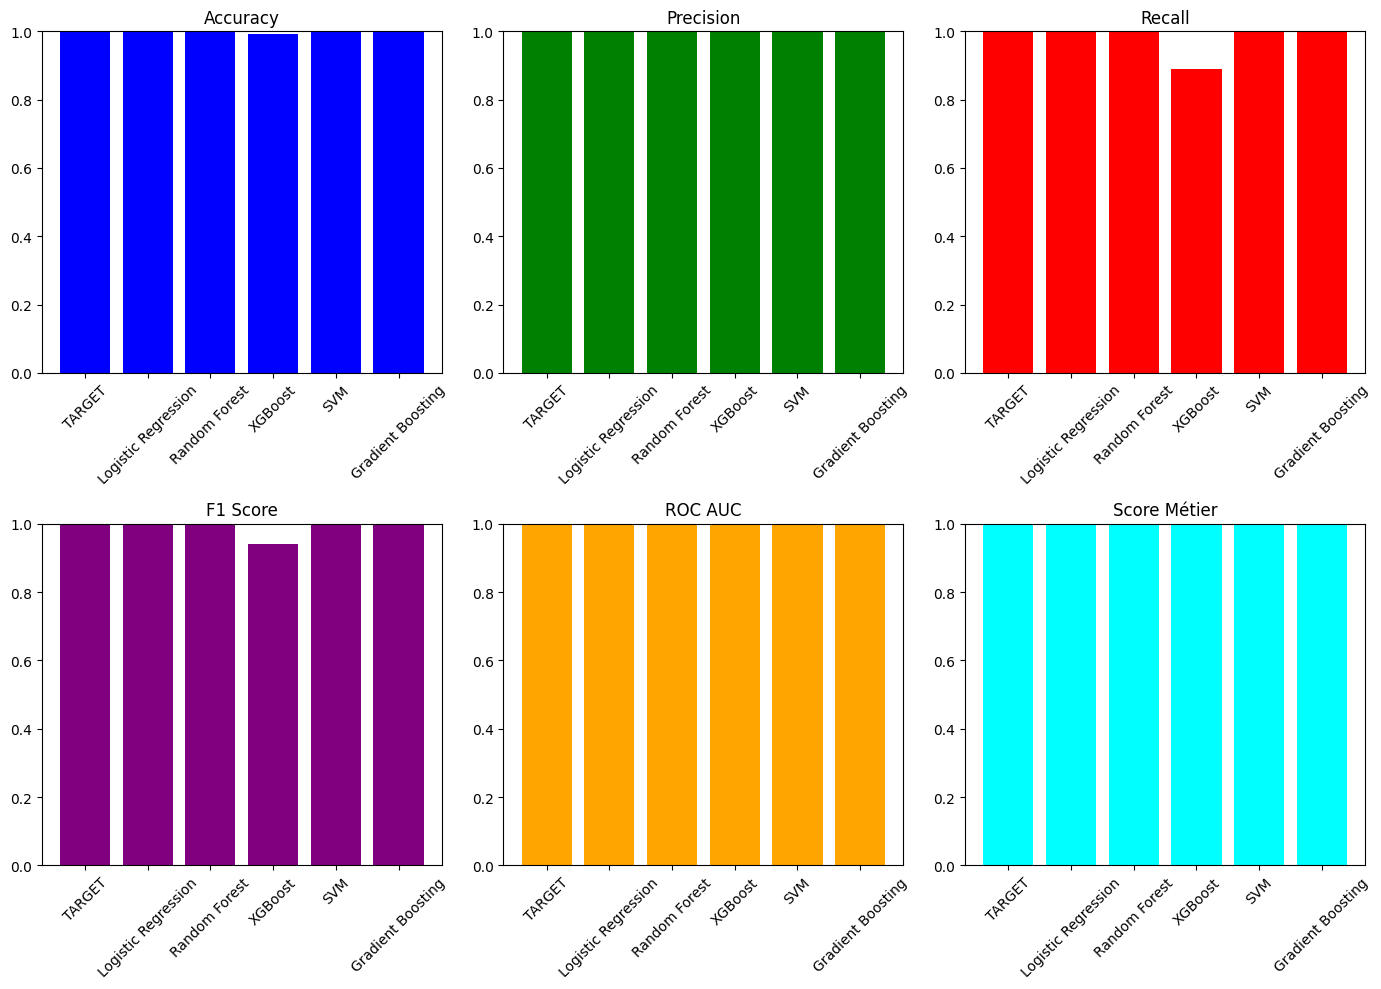

In [140]:
df = model_performance_metrics
# Configurer la taille de la figure
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 3, 1)
plt.bar(df['model'], df['accuracy'], color='blue')
plt.title('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Precision
plt.subplot(2, 3, 2)
plt.bar(df['model'], df['precision'], color='green')
plt.title('Precision')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Recall
plt.subplot(2, 3, 3)
plt.bar(df['model'], df['recall'], color='red')
plt.title('Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# F1 Score
plt.subplot(2, 3, 4)
plt.bar(df['model'], df['f1_score'], color='purple')
plt.title('F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# ROC AUC
plt.subplot(2, 3, 5)
plt.bar(df['model'], df['roc_auc'], color='orange')
plt.title('ROC AUC')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Score Métier
plt.subplot(2, 3, 6)
plt.bar(df['model'], df['score_metier'], color='cyan')
plt.title('Score Métier')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_8302/941466282.py:32: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



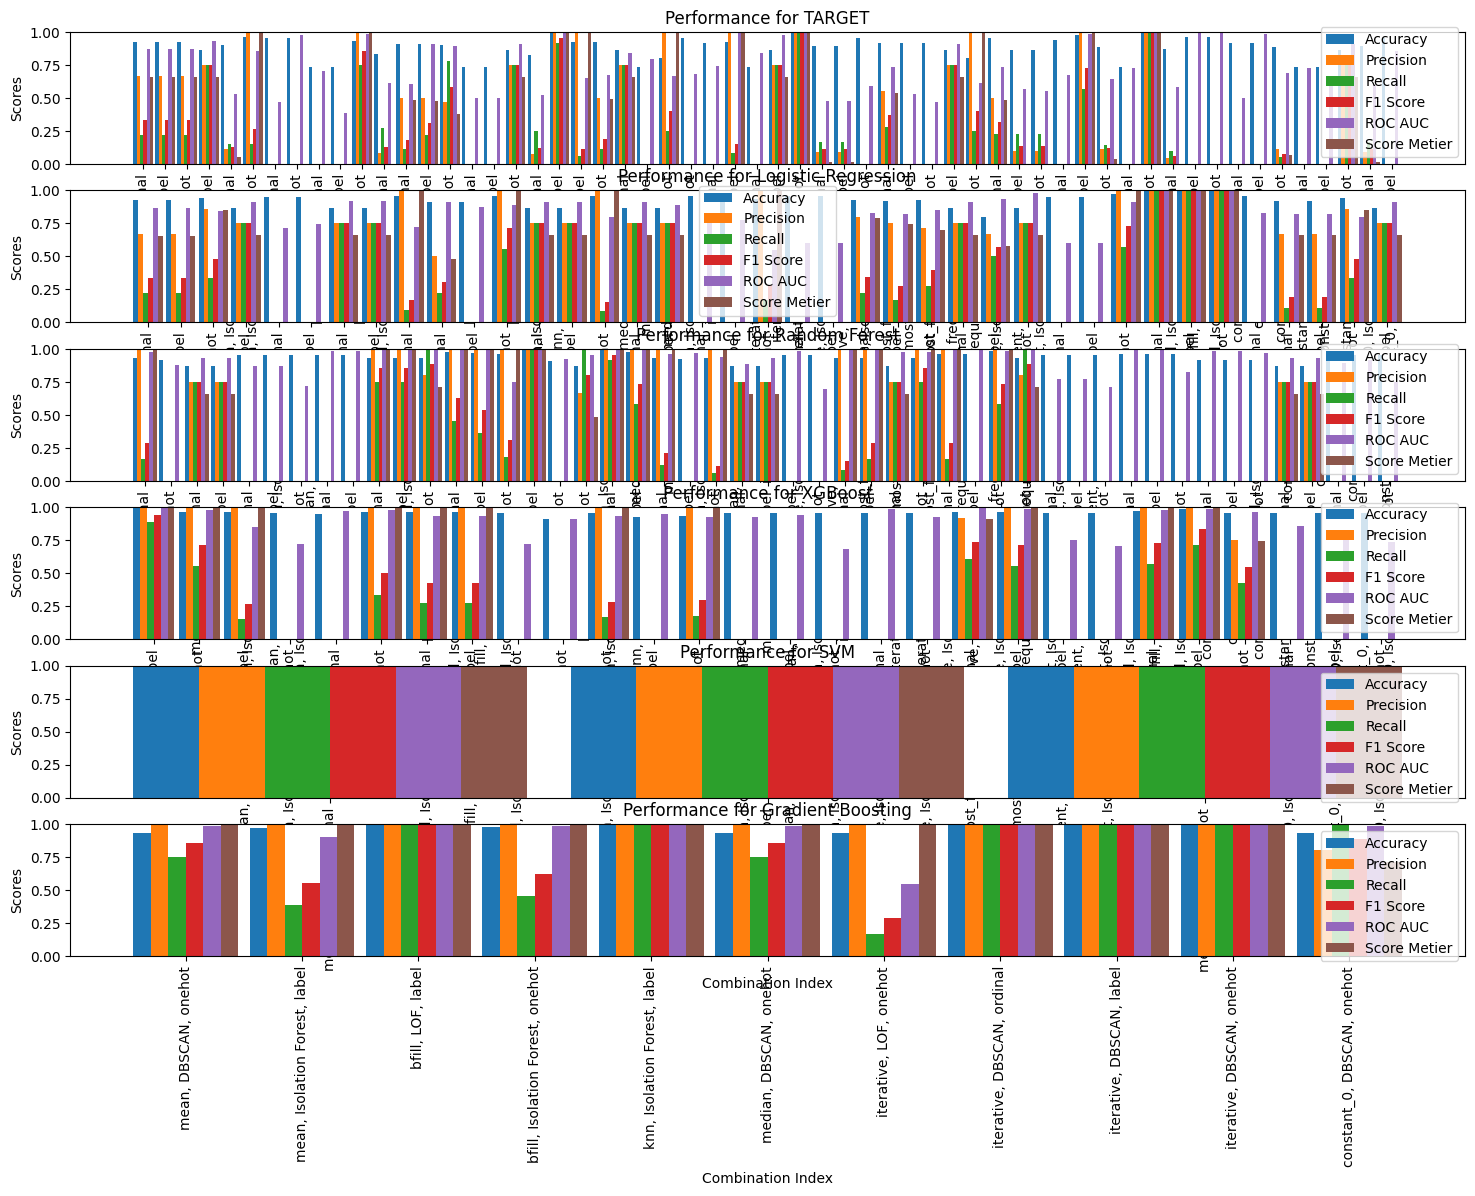

In [17]:
df = model_performance_metrics
# Séparer les données par modèle
models = df['model'].unique()
model_dfs = {model: df[df['model'] == model] for model in models}

# Configurer la taille de la figure pour plusieurs sous-graphes
plt.figure(figsize=(18, 12))

# Itérer à travers chaque modèle et créer des graphiques
for i, model in enumerate(models, 1):
    model_df = model_dfs[model]
    x_labels = [f"{row['imputation_method']}, {row['outlier_method']}, {row['encoding_method']}" for idx, row in model_df.iterrows()]
    
    plt.subplot(len(models), 1, i)
    bar_width = 0.15
    index = range(len(model_df))
    
    plt.bar(index, model_df['accuracy'], bar_width, label='Accuracy')
    plt.bar([p + bar_width for p in index], model_df['precision'], bar_width, label='Precision')
    plt.bar([p + bar_width*2 for p in index], model_df['recall'], bar_width, label='Recall')
    plt.bar([p + bar_width*3 for p in index], model_df['f1_score'], bar_width, label='F1 Score')
    plt.bar([p + bar_width*4 for p in index], model_df['roc_auc'], bar_width, label='ROC AUC')
    plt.bar([p + bar_width*5 for p in index], model_df['score_metier'], bar_width, label='Score Metier')
    
    plt.title(f'Performance for {model}')
    plt.xlabel('Combination Index')
    plt.ylabel('Scores')
    plt.xticks([p + bar_width*2.5 for p in index], x_labels, rotation=90)
    plt.ylim(0, 1)
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [41]:
df = model_performance_metrics
# Définir les seuils pour chaque métrique
thresholds = {
    'accuracy': {'high': 0.95, 'low': 0.85},
    'precision': {'high': 0.75, 'low': 0.5},
    'recall': {'high': 0.7, 'low': 0.4},
    'f1_score': {'high': 0.7, 'low': 0.4},
    'roc_auc': {'high': 0.82, 'low': 0.7},
    'score_metier': {'high': 1, 'low': 0}
}

# Fonction pour classifier les valeurs
def classify_performance(value, metric):
    if value <= thresholds[metric]['high']:
        return 'Juste'
    elif value >= thresholds[metric]['low']:
        return 'Correct'
    else:
        return 'Fausse'

In [37]:
# Appliquer la classification à chaque métrique pour chaque modèle
classification_results = df.copy()
for metric in thresholds.keys():
    classification_results[metric + '_classification'] = classification_results[metric].apply(lambda x: classify_performance(x, metric))

# Afficher les résultats de la classification
classification_display = classification_results[['model', 'imputation_method', 'outlier_method', 'encoding_method',
                        'accuracy_classification', 'precision_classification', 'recall_classification',
                        'f1_score_classification', 'roc_auc_classification', 'score_metier_classification']]

classification_display

,model,imputation_method,outlier_method,encoding_method,accuracy_classification,precision_classification,recall_classification,f1_score_classification,roc_auc_classification,score_metier_classification
0,TARGET,mean,LOF,ordinal,Correct,Correct,Fausse,Fausse,Correct,Correct
1,Logistic Regression,mean,LOF,ordinal,Correct,Correct,Fausse,Fausse,Correct,Correct
2,Random Forest,mean,LOF,ordinal,Correct,Juste,Fausse,Fausse,Juste,Juste
3,TARGET,mean,LOF,label,Correct,Correct,Fausse,Fausse,Correct,Correct
4,Logistic Regression,mean,LOF,label,Correct,Correct,Fausse,Fausse,Correct,Correct
...,...,...,...,...,...,...,...,...,...,...
183,TARGET,constant_0,Isolation Forest,label,Juste,Fausse,Fausse,Fausse,Correct,Fausse
184,Random Forest,constant_0,Isolation Forest,label,Juste,Fausse,Fausse,Fausse,Juste,Fausse
185,XGBoost,constant_0,Isolation Forest,label,Juste,Fausse,Fausse,Fausse,Correct,Fausse
186,Random Forest,constant_0,Isolation Forest,onehot,Juste,Fausse,Fausse,Fausse,Correct,Fausse


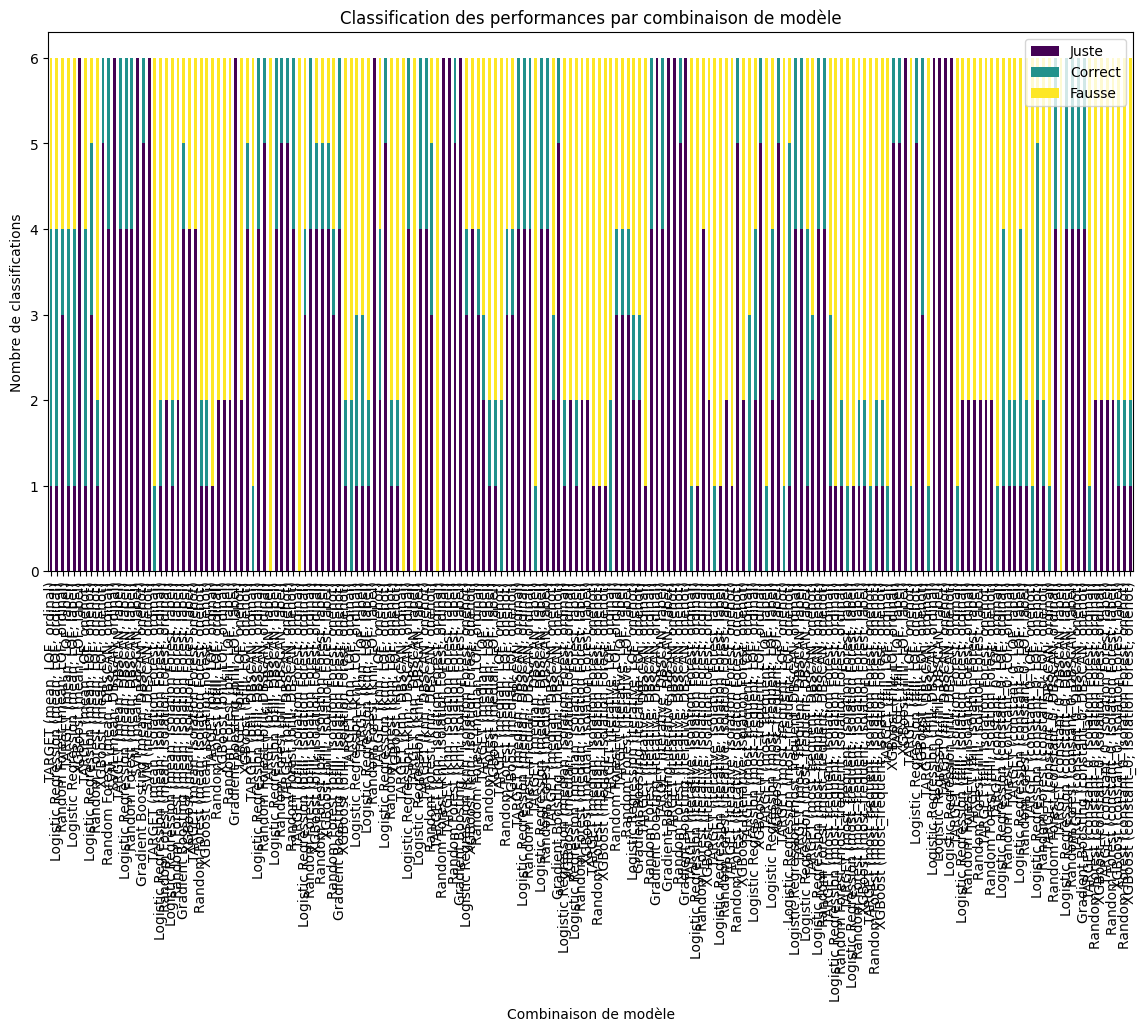

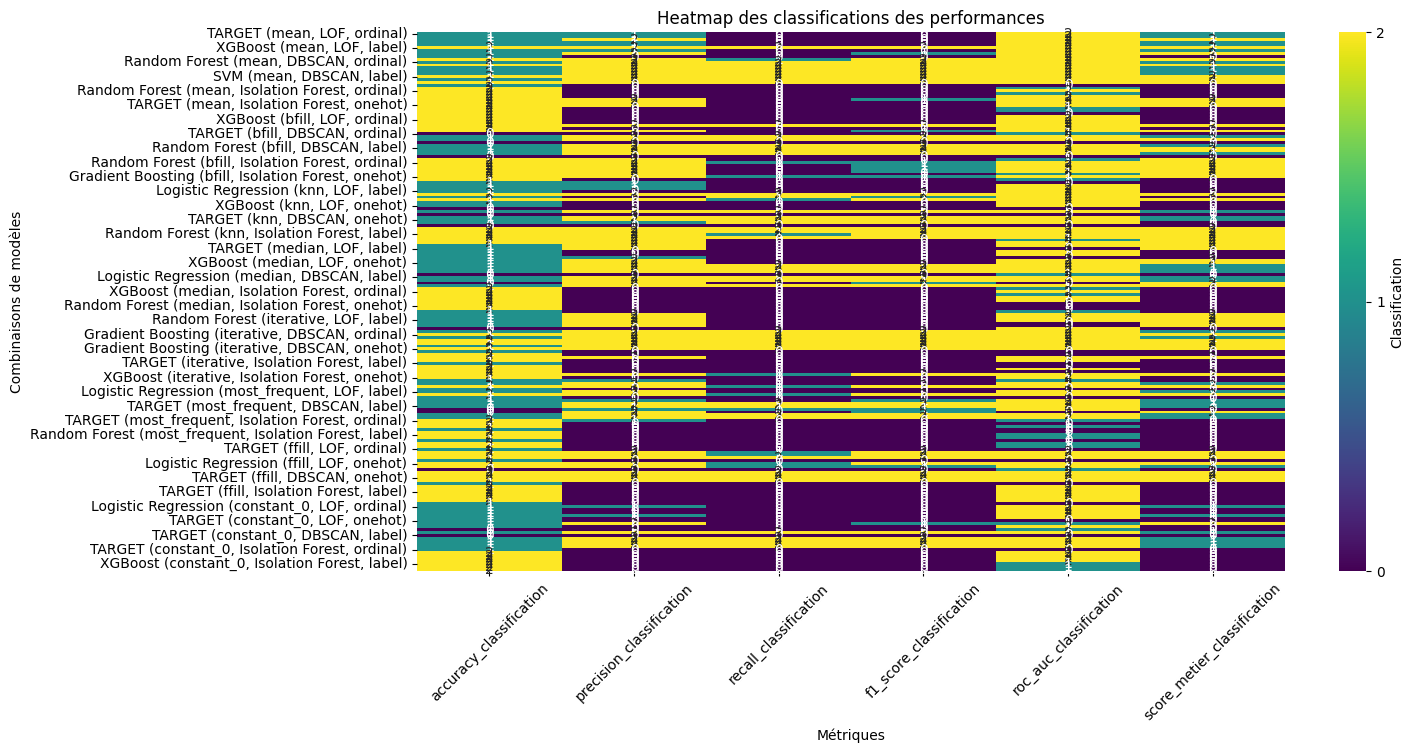

In [43]:
df = model_performance_metrics
# Préparation des données pour le graphique en barres empilées
classification_counts = classification_results.apply(lambda x: pd.Series({
    'Juste': (x == 'Juste').sum(),
    'Correct': (x == 'Correct').sum(),
    'Fausse': (x == 'Fausse').sum()
}), axis=1)

classification_counts['model_combination'] = classification_results.apply(lambda x: f"{x['model']} ({x['imputation_method']}, {x['outlier_method']}, {x['encoding_method']})", axis=1)

# Graphique en barres empilées
classification_counts.set_index('model_combination')[['Juste', 'Correct', 'Fausse']].plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Classification des performances par combinaison de modèle')
plt.xlabel('Combinaison de modèle')
plt.ylabel('Nombre de classifications')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

# Préparation des données pour la heatmap
heatmap_data = classification_results[['accuracy_classification', 'precision_classification', 'recall_classification', 'f1_score_classification', 'roc_auc_classification', 'score_metier_classification']].applymap(lambda x: 2 if x == 'Juste' else (1 if x == 'Correct' else 0))

# Ajout des noms de modèles et de combinaisons pour les étiquettes
heatmap_data.index = classification_results.apply(lambda x: f"{x['model']} ({x['imputation_method']}, {x['outlier_method']}, {x['encoding_method']})", axis=1)

# Heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2], 'label': 'Classification'})
plt.title('Heatmap des classifications des performances')
plt.xlabel('Métriques')
plt.ylabel('Combinaisons de modèles')
plt.xticks(rotation=45)
plt.show()

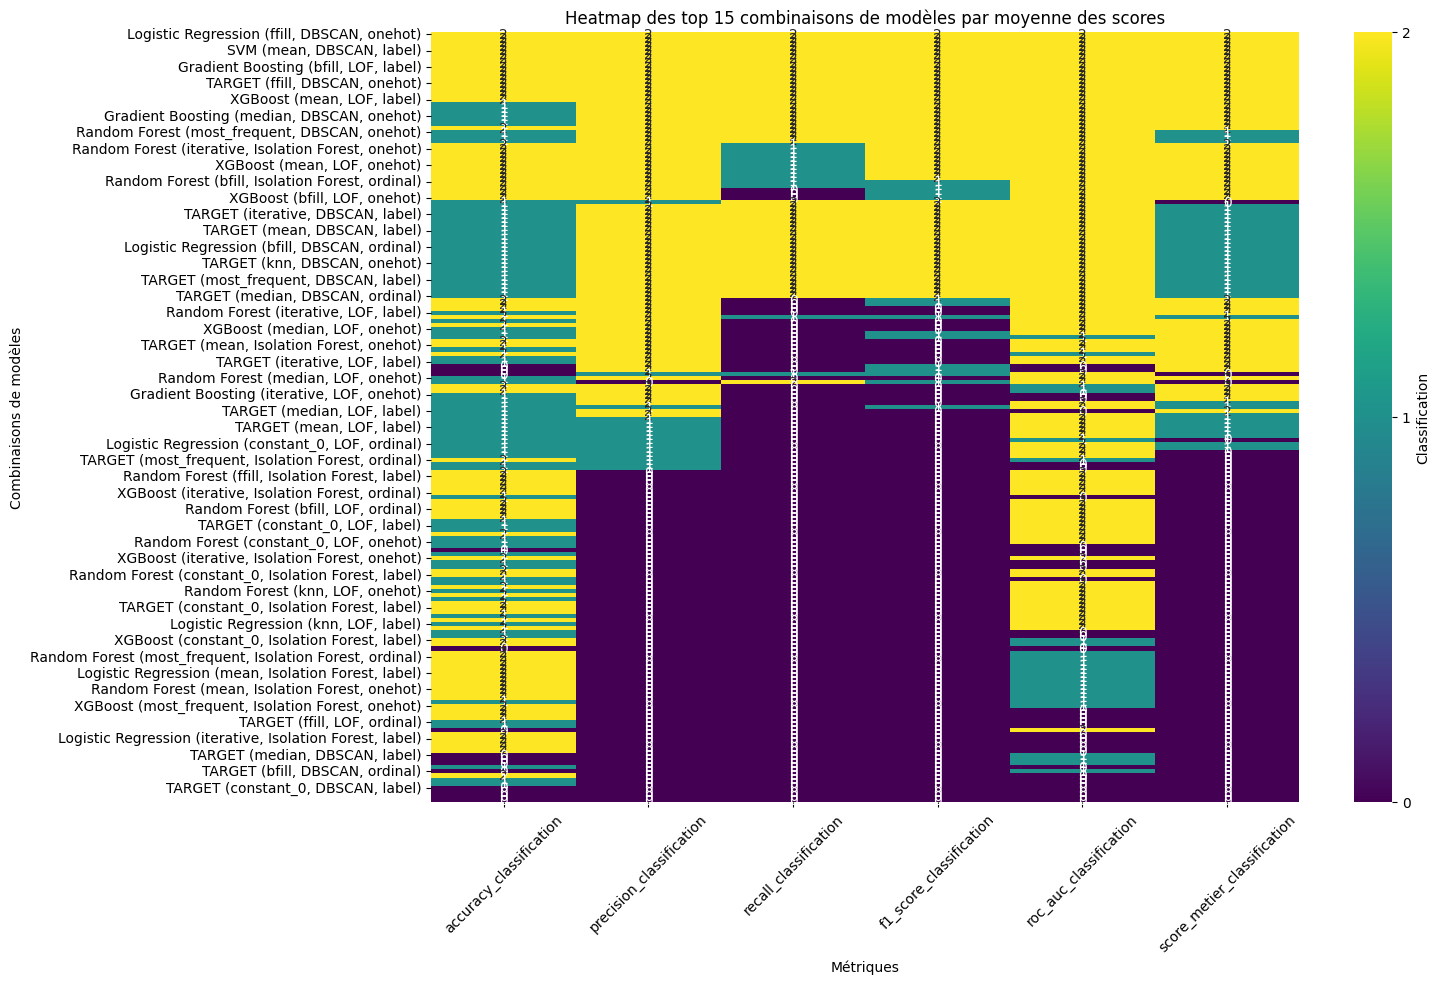

In [44]:
# Appliquer la classification à chaque métrique pour chaque modèle
classification_results = df.copy()
for metric in thresholds.keys():
    classification_results[metric + '_classification'] = classification_results[metric].apply(lambda x: classify_performance(x, metric))

# Calculer la moyenne des scores évalués
classification_results['average_score'] = classification_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'score_metier']].mean(axis=1)

# Trier les résultats par la moyenne des scores et prendre le top 15
top_15_average_scores = classification_results.sort_values(by='average_score', ascending=False)

# Préparation des données pour la heatmap des top 15
classification_score = {
    'Juste': 2,
    'Correct': 1,
    'Fausse': 0
}
heatmap_top_15_average_scores_data = top_15_average_scores[['accuracy_classification', 'precision_classification', 'recall_classification', 'f1_score_classification', 'roc_auc_classification', 'score_metier_classification']].applymap(lambda x: classification_score[x])

# Ajout des noms de modèles et de combinaisons pour les étiquettes
heatmap_top_15_average_scores_data.index = top_15_average_scores.apply(lambda x: f"{x['model']} ({x['imputation_method']}, {x['outlier_method']}, {x['encoding_method']})", axis=1)

# Heatmap des top 15 selon la moyenne des scores
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_top_15_average_scores_data, annot=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2], 'label': 'Classification'})
plt.title('Heatmap des top combinaisons de modèles par moyenne des scores')
plt.xlabel('Métriques')
plt.ylabel('Combinaisons de modèles')
plt.xticks(rotation=45)
plt.show()

# Sélection du Modèle Final et Hyperparameter Tuning

After evaluating the models, the best performing model can be selected and further tuned using hyperparameter optimization.

In [114]:
def objective(trial, X_train, y_train):
    # Define your objective function for Optuna here
    classifier_name = trial.suggest_categorical('classifier', ['LogisticRegression', 'RandomForestClassifier'])
    if classifier_name == 'LogisticRegression':
        classifier = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e2),
            max_iter=trial.suggest_int('max_iter', 100, 1000)
        )
    else:
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 300),
            max_depth=trial.suggest_int('max_depth', 2, 32)
        )
    
    # Add the classifier to a pipeline
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    # Train and evaluate the pipeline
    pipeline.fit(X_train, y_train)
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3).mean()
    return score

def find_file_path(base_path, filename, testing_mode, testing_folder_name):
    # Determine the search path based on whether testing mode is enabled
    search_path = os.path.join(base_path, testing_folder_name) if testing_mode else base_path
    # Search for the file in the specified path
    for root, _, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

def select_and_tune_best_model(performance_df_path, base_path, output_folder, target_column, testing_mode=False, testing_folder_name='testing'):
    # Load the performance dataframe
    performance_df = pd.read_csv(performance_df_path)
    
    # Select the best model row based on roc_auc
    best_model_row = performance_df.loc[performance_df['roc_auc'].idxmax()]
    best_model_name = best_model_row['model']
    print(f"Best model: {best_model_name} with ROC AUC: {best_model_row['roc_auc']}")

    # Print the available models in the dictionary
    print(f"Available models in the dictionary: {list(models.keys())}")

    # Find the path of the saved model
    model_path = find_file_path(base_path, f'best_{best_model_name}_model.pkl', testing_mode, testing_folder_name)
    if model_path is None:
        print(f"Model file best_{best_model_name}_model.pkl not found in {base_path}")
        return None
    
    # Load the best pipeline
    best_pipeline = joblib.load(model_path)

    # Find the path of the training data
    data_path = find_file_path(base_path, 'train_data.csv', testing_mode, testing_folder_name)
    test_data_path = find_file_path(base_path, 'test_data.csv', testing_mode, testing_folder_name)
    
    if data_path is None:
        print(f"Training data file train_data.csv not found in {base_path}")
        return None

    if test_data_path is None:
        print(f"Testing data file test_data.csv not found in {base_path}")
        return None
    print(f"Testing data path : {test_data_path}")
    # Prepare the training data
    train_data = pd.read_csv(data_path)
    X_train = train_data.drop(target_column, axis=1)
    y_train = train_data[target_column]

    # Hyperparameter tuning of the best model with Optuna
    study = optuna.create_study(direction='maximize')
    
    # Add a progress bar for the optimization
    n_trials = 100
    pbar = tqdm(total=n_trials, desc="Optimizing Hyperparameters")
    
    def objective_with_progress(trial):
        result = objective(trial, X_train, y_train)
        pbar.update(1)
        return result
    
    study.optimize(objective_with_progress, n_trials=n_trials)
    pbar.close()

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('  Value: ', trial.value)
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # Check that the model is in the `models` dictionary
    if best_model_name not in models:
        print(f"Model {best_model_name} not found in the models dictionary. Available models are: {list(models.keys())}")
        return None

    # Update the best model with the best hyperparameters found
    best_classifier = models[best_model_name]['model']
    best_params = {k: v for k, v in trial.params.items() if k != 'classifier'}
    best_classifier.set_params(**best_params)

    # Redefine the pipeline with the best hyperparameters
    best_pipeline = Pipeline(steps=[
        ('classifier', best_classifier)
    ])

    # Train the best pipeline on the full data with a progress bar
    epochs = 1  # Number of epochs for the training loop (example)
    pbar = tqdm(total=epochs, desc="Training Model")
    for _ in range(epochs):
        best_pipeline.fit(X_train, y_train)
        pbar.update(1)
    pbar.close()

    # Save the trained pipeline in the output folder
    os.makedirs(output_folder, exist_ok=True)
    output_model_path = os.path.join(output_folder, f'hcdr_model.pkl')
    joblib.dump(best_pipeline, output_model_path)
    train_data_output_path = os.path.join(output_folder, f'train_data.csv')
    shutil.copyfile(data_path, train_data_output_path)
    print(f"Training data copied at {train_data_output_path}")
    test_data_output_path = os.path.join(output_folder, f'test_data.csv')
    shutil.copyfile(test_data_path, test_data_output_path)
    print(f"Testing data copied at {test_data_output_path}")
    
    
    print(f"Model saved at {output_model_path}")

    return best_pipeline

In [ ]:
select_and_tune_best_model(
    performance_df_path=f"{LOCAL_EXPORT_MODELIZATION_EVALUATION_RESULT_FOLDER_PATH}/model_performance_metrics.csv", 
    base_path=LOCAL_EXPORT_MODELIZATION_FOLDER_PATH, 
    output_folder=LOCAL_EXPORT_SELECT_AND_TUNE_BEST_MODEL,
    testing_folder_name=TESTING_MODE_SUB_FOLDER_NAME,
    testing_mode=TESTING_MODE, 
    target_column="TARGET")

# Interpreting and Explaining Machine Learning Models

## Introduction
Interpreting and explaining machine learning models is crucial for understanding how models make decisions, ensuring transparency, and building trust with stakeholders. SHAP (SHapley Additive exPlanations) is a powerful tool for explaining individual predictions and understanding the global behavior of models.

## Loading and Preparing Data

The first step is to load and prepare the training and testing data. This involves:

1. **Loading the Data**: Reading the CSV files for training and testing data.
2. **Separating Features and Target**: Separating the independent variables (features) from the dependent variable (target).
3. **Normalizing the Data**: Scaling the features to have a mean of 0 and a standard deviation of 1.


In [137]:
def load_and_prepare_data(train_data_path, test_data_path, target_column):
    # Charger les données d'entraînement
    train_data = pd.read_csv(train_data_path)
    
    # Vérifier si la colonne cible existe dans les données d'entraînement
    if target_column not in train_data.columns:
        raise KeyError(f"'{target_column}' not found in training data columns.")
    
    # Séparer les features et les cibles pour les données d'entraînement
    X_train = train_data.drop(target_column, axis=1)
    y_train = train_data[target_column]
    feature_names = X_train.columns.tolist()  # Convertir en liste
    
    # Charger les données de test
    test_data = pd.read_csv(test_data_path)
    
    # Ajouter les colonnes manquantes aux données de test
    for col in feature_names:
        if col not in test_data.columns:
            test_data[col] = 0  # Remplir avec des zéros ou une autre valeur par défaut appropriée
    
    # Assurer que les colonnes sont dans le même ordre
    X_test = test_data[feature_names]
    y_test = test_data[target_column] if target_column in test_data.columns else None

    # Normaliser les données
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, feature_names

def explain_model_with_shap(model_path, train_data_path, test_data_path, target_column):
    # Charger votre modèle exporté
    pipeline = joblib.load(model_path)
    model = pipeline.named_steps['classifier']  # Extraire le modèle XGBoost du pipeline

    # Charger et préparer les données
    X_train, y_train, X_test, y_test, feature_names = load_and_prepare_data(train_data_path, test_data_path, target_column)

    # Convertir les données en DMatrix
    dtest = DMatrix(X_test, feature_names=feature_names)

    # Créer un explainer SHAP avec la classe TreeExplainer pour XGBoost
    explainer = shap.TreeExplainer(model)

    # Calculer les valeurs SHAP
    shap_values = explainer.shap_values(dtest)
    shap_values_train = explainer.shap_values(DMatrix(X_train, feature_names=feature_names))

    # Préparer les données pour Plotly
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    shap_df['prediction'] = pipeline.predict(X_test)

    # Visualiser les explications en 3D
    fig = px.scatter_3d(shap_df, x=feature_names[0], y=feature_names[1], z=feature_names[2], 
                        color='prediction', size_max=18, opacity=0.7, 
                        title='SHAP Values 3D Visualization')

    fig.update_layout(scene=dict(
                        xaxis_title=feature_names[0],
                        yaxis_title=feature_names[1],
                        zaxis_title=feature_names[2]),
                        margin=dict(l=0, r=0, b=0, t=40))

    fig.show()

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot')
    plt.show()

    # SHAP Dependence Plot
    for feature in feature_names[:3]:  # Limité à trois features pour l'exemple
        shap.dependence_plot(feature, shap_values, X_test, feature_names=feature_names, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.show()

    # SHAP Force Plot pour la première prédiction
    shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[0, :], feature_names=feature_names, matplotlib=True)
    plt.title('SHAP Force Plot for First Prediction')
    plt.show()

    # SHAP Waterfall Plot pour la première prédiction
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test[0], feature_names=feature_names), show=False)
    plt.title('SHAP Waterfall Plot for First Prediction')
    plt.show()

/tmp/ipykernel_8302/3191265488.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_8302/3191265488.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_8302/3191265488.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_8302/3191265488.py:20: Performance

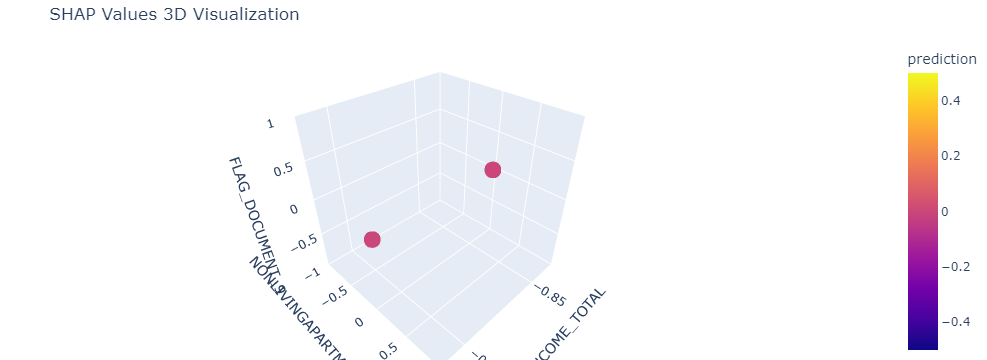

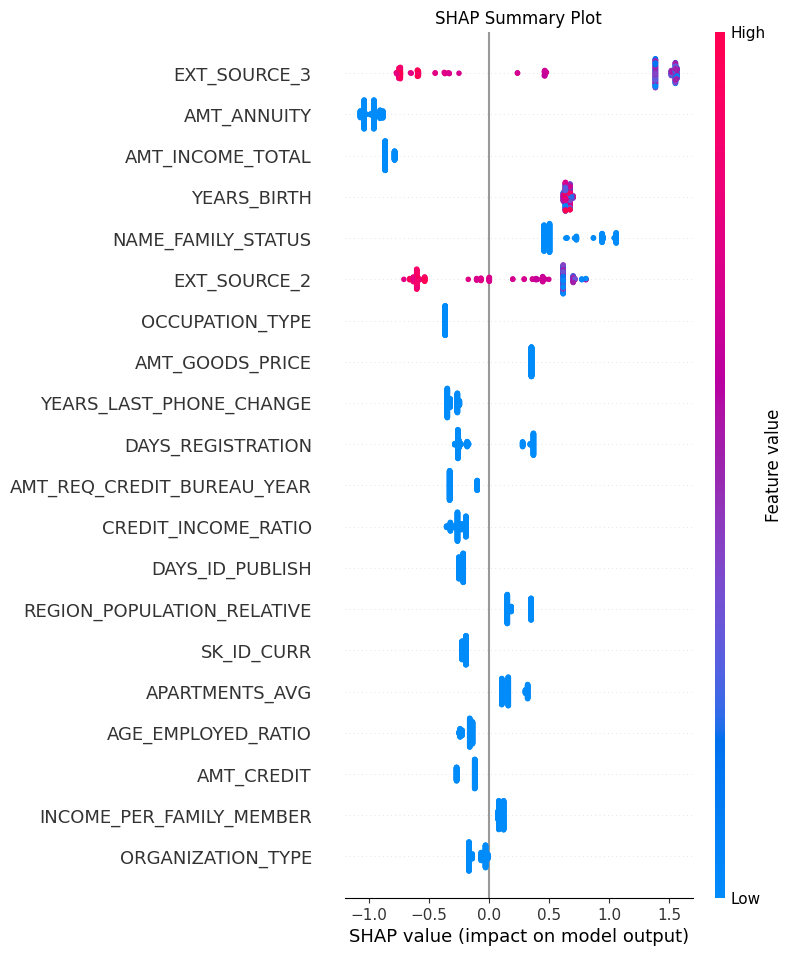

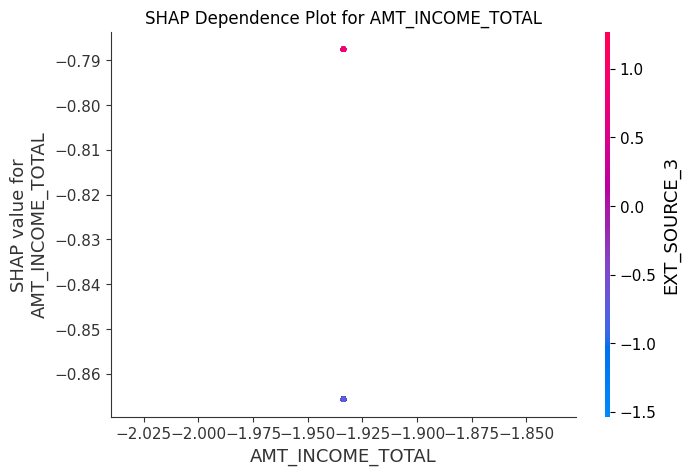

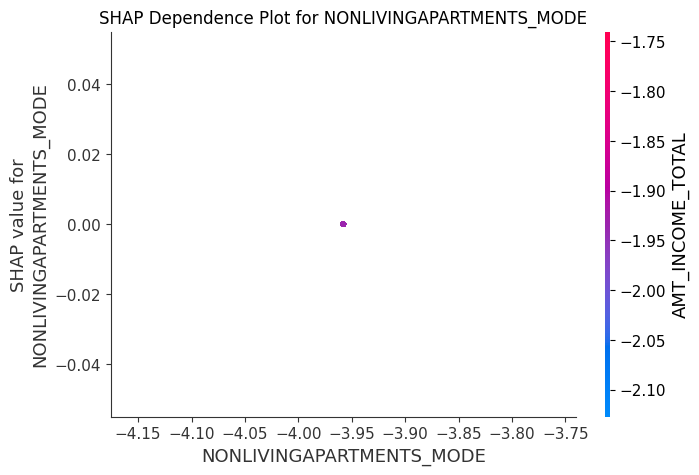

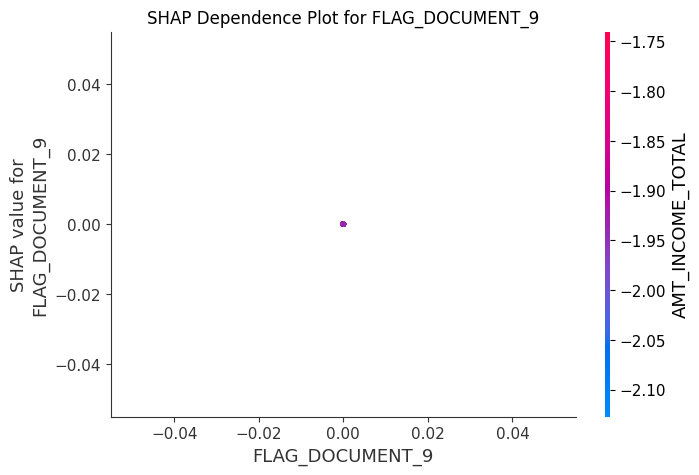

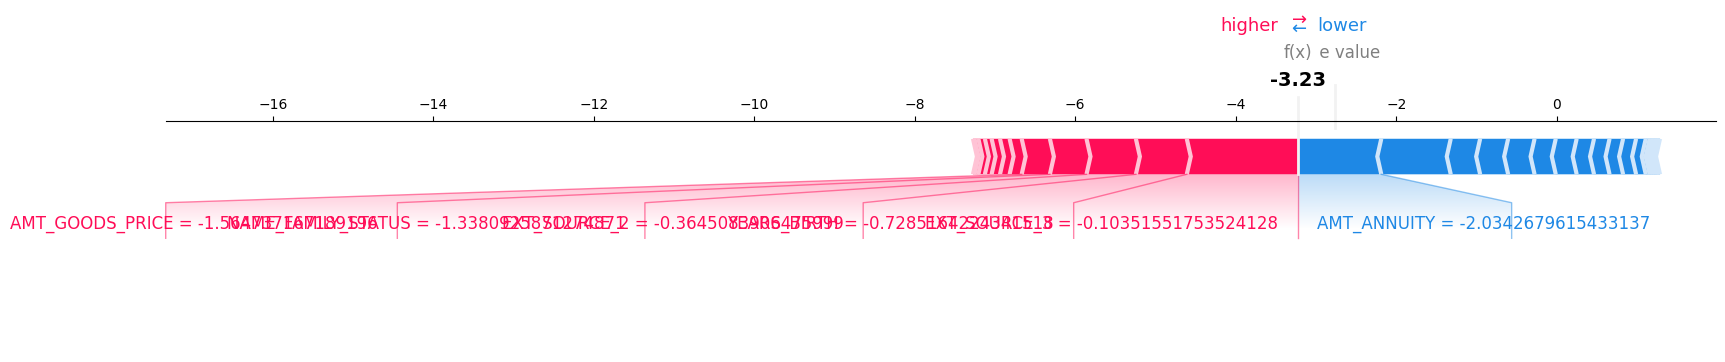

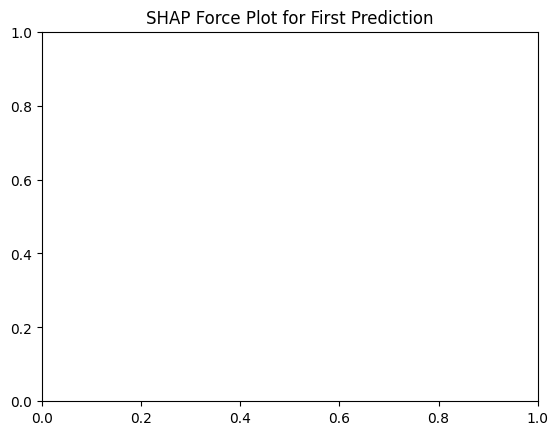

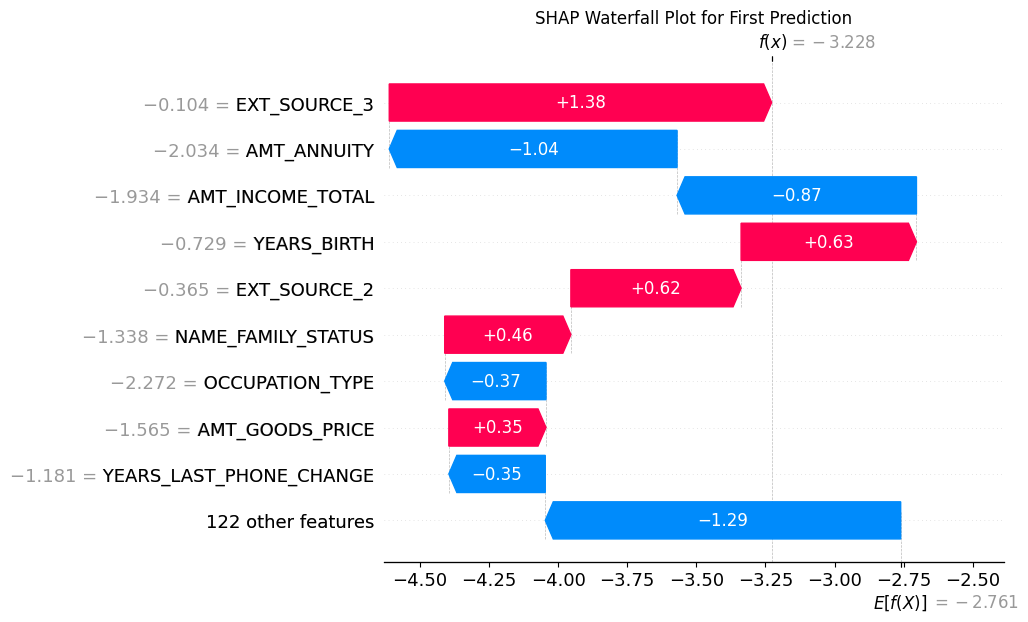

In [138]:
explain_model_with_shap(
    model_path=f"{LOCAL_EXPORT_SELECT_AND_TUNE_BEST_MODEL}/hcdr_model.pkl", 
    train_data_path=f"{LOCAL_EXPORT_SELECT_AND_TUNE_BEST_MODEL}/train_data.csv", 
    test_data_path=f"{LOCAL_EXPORT_SELECT_AND_TUNE_BEST_MODEL}/test_data.csv", 
    target_column='TARGET')
